# 3. Loading and fitting multiple diffraction patterns

If a number of diffraction patterns are collected over time they can be automatically fitted and the change in peaks over time measured. The change in the positions or heights of the peaks can then be correlated to material properties. We call the fitting of multiple **spectra** an **Experiment**.

In the example files folder there is a sequence of 10 diffraction patterns which we will use for demonstration.

## 3.1. Fitting a peak at multiple times

The first thing to do is to load an `FittingExperiment` object - this contains some metadata about the experiment and will hold one `FitSpectrum` for each diffraction pattern. The *first_cake_angle*, *cakes_to_fit*, *peak_params* and *merge_cakes* parameters are the same as before. The *spectrum_time* parameter sets the number of seconds between each spectrum in the sequence - this value is used to appropriately label the x-axis on plots. The *file_stub* parameter is used to locate the files. To use all of the spectra in a folder that are sequentially numbered - provide the stub of the file name with a star (wildcard).

Once the `FittingExperiment` object is loaded, the `run_analysis` method runs the fit over all of the specified files.

In [1]:
%matplotlib inline

import xrdfit.spectrum_fitting as spectrum_fitting
from xrdfit.spectrum_fitting import PeakParams

first_cake_angle = 90
cakes_to_fit = [36, 1, 2]
peak_params = PeakParams('1', (2.75, 2.95))
merge_cakes = True

spectrum_time = 1
file_stub = "../example_data/adc_041_7Nb_NDload_700C_15mms_*"

experiment = spectrum_fitting.FittingExperiment(spectrum_time, file_stub, first_cake_angle, 
                                                cakes_to_fit, peak_params, merge_cakes)

experiment.run_analysis()

Processing 10 diffraction patterns.



Analysis complete.


The results are hierarchically stored in the `FitExperiment` object and can be accessed directly if you wish. However, it is probably easier to use the `FitExperiment` helper methods described below to plot the results rather than accessing the raw fit data directly.

The `peak_names` method lists the names of the fitted peaks specified in the `PeakParams` objects. The `fit_parameters` method gives a list of the names of the fit parameters for a particular peak.

In [2]:
print(experiment.peak_names())
print(experiment.fit_parameters('1'))

['1']
['maximum_1_center', 'maximum_1_sigma', 'maximum_1_fraction', 'maximum_1_amplitude', 'background']


To plot a parameter for a fit over time use the `plot_fit_parameter` method. To plot all of the parameters for all of the peaks use a loop:

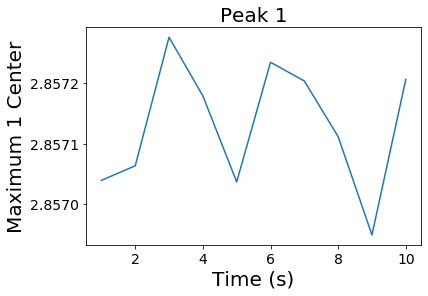

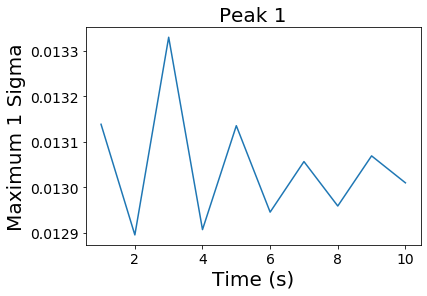

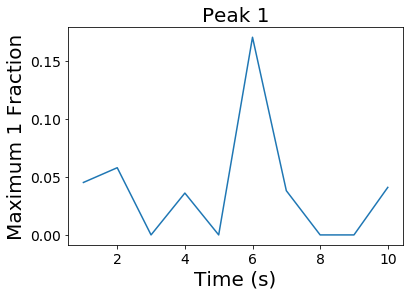

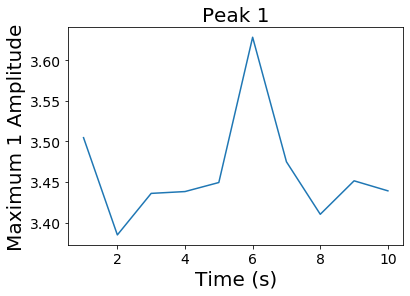

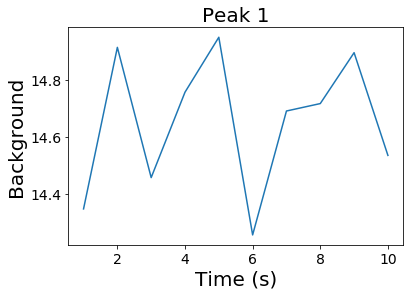

In [3]:
for peak_name in experiment.peak_names():
    for parameter in experiment.fit_parameters(peak_name):
        experiment.plot_fit_parameter(peak_name, parameter)

In this example the peak does not do anything very interesting. This is because the 10 example files represent only a short time period where little was changing in the material.

## 3.2. Fitting multiple peaks at multiple times
We can set up a larger analysis to fit multiple peaks over time. It is probably a good workflow to determine good values for the `PeakParams` on a single file first to check that the fits are good and then use them to run over multiple files. Here we take the `PeakParams` determined in one of the earlier tutorial notebooks.

In [4]:
first_cake_angle = 90
cakes_to_fit = [36, 1, 2]


peak_params = [PeakParams('1', (2.75, 2.95)),
               PeakParams('2', (3.02, 3.15)),
               PeakParams('3',  (3.15, 3.30), [(3.19, 3.22), (3.24, 3.26)]),
               PeakParams('4', (4.13, 4.30))]
merge_cakes = True

spectrum_time = 1
file_stub = "../example_data/adc_041_7Nb_NDload_700C_15mms_*"

experiment = spectrum_fitting.FittingExperiment(spectrum_time, file_stub, first_cake_angle, 
                                                cakes_to_fit, peak_params, merge_cakes)

experiment.run_analysis()

Processing 10 diffraction patterns.



Analysis complete.


In [5]:
print(experiment.peak_names())
for peak_name in experiment.peak_names():
    print(experiment.fit_parameters(peak_name))

['1', '2', '3', '4']
['maximum_1_center', 'maximum_1_sigma', 'maximum_1_fraction', 'maximum_1_amplitude', 'background']
['maximum_1_center', 'maximum_1_sigma', 'maximum_1_fraction', 'maximum_1_amplitude', 'background']
['maximum_1_center', 'maximum_1_sigma', 'maximum_1_fraction', 'maximum_1_amplitude', 'maximum_2_center', 'maximum_2_sigma', 'maximum_2_fraction', 'maximum_2_amplitude', 'background']
['maximum_1_center', 'maximum_1_sigma', 'maximum_1_fraction', 'maximum_1_amplitude', 'background']


Here we can see that we have the four peaks we have fitted. Notice that the third peak has two sets of fit parameters. Since the third peak is fitted with a compound fit, the first fit corresponds to the first maxima and the second the second maxima.

As before we can loop over the names though this time we plot just the centre of the fit. The second maxima will only be plotted for the peak where it exists.

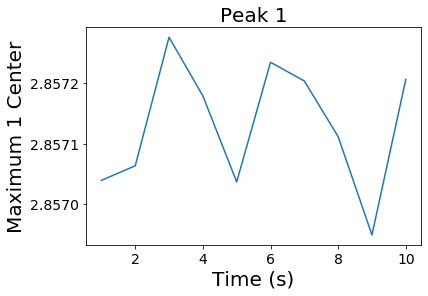

Unknown fit parameter maximum_2_center for peak 1


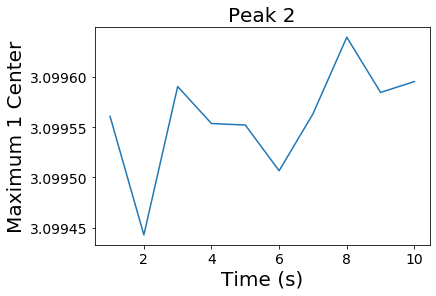

Unknown fit parameter maximum_2_center for peak 2


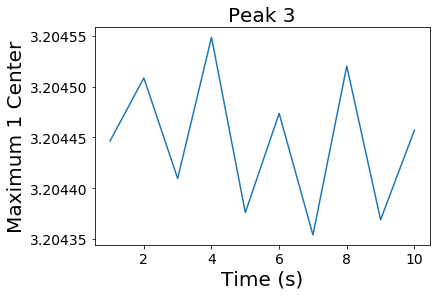

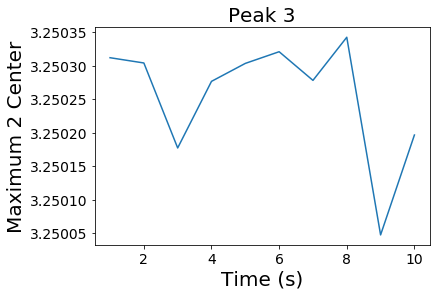

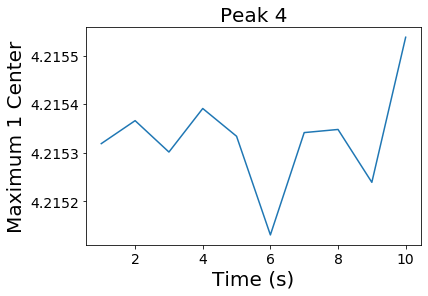

Unknown fit parameter maximum_2_center for peak 4


In [6]:
for peak_name in experiment.peak_names():
    experiment.plot_fit_parameter(peak_name, "maximum_1_center")
    experiment.plot_fit_parameter(peak_name, "maximum_2_center")

## 3.3. Plotting fits

If you notice the fits going very slowly at certain times or the plotted parameters show unexpected values, it is likely the fit parameters need adjusting a little. To get an idea of how the fits went you can plot the fits from a timeseries using the `plot_fits` method. By defualt the method prints plots for 5 timesteps, evenly spaced in time, plotting one plot for each fitted peak.

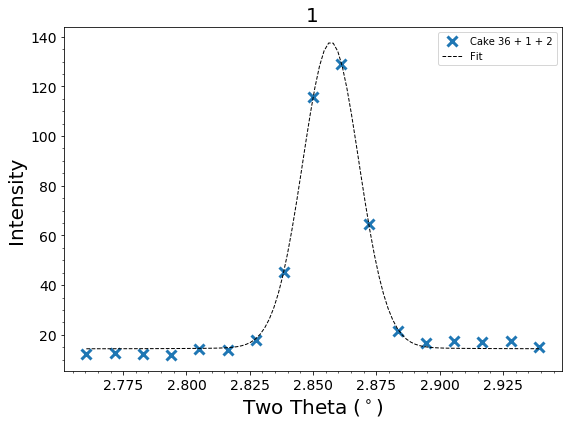

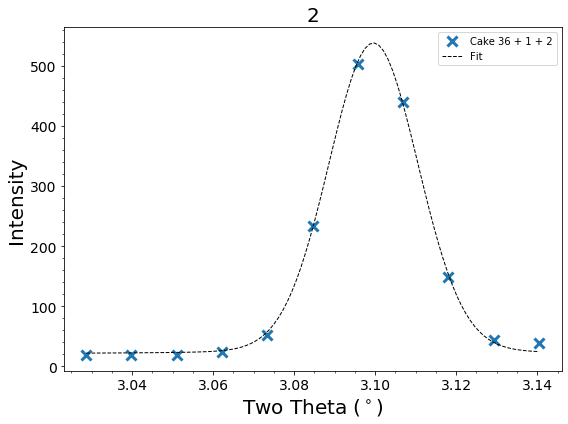

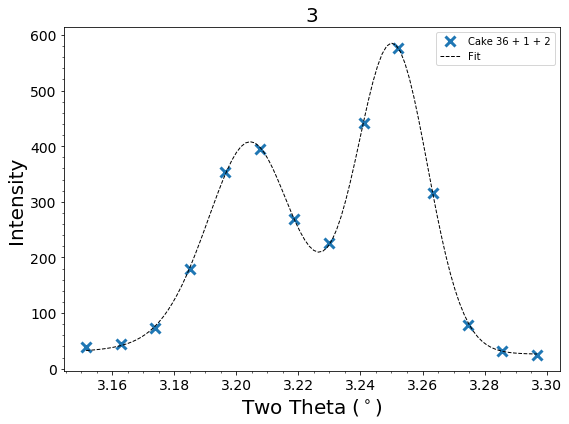

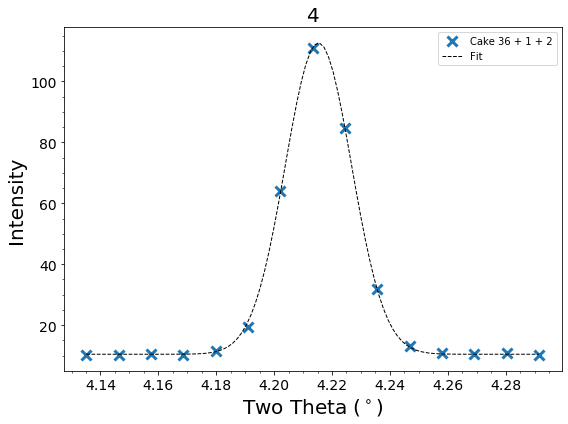

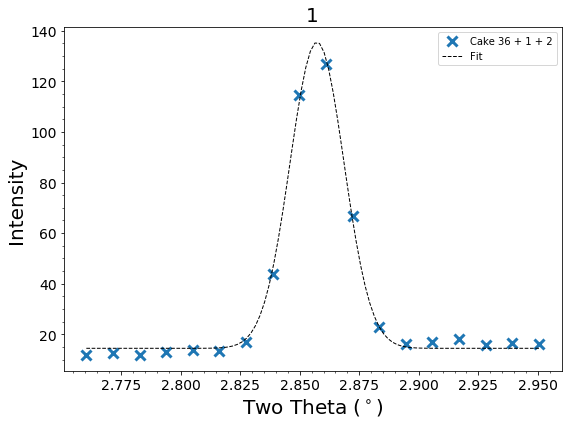

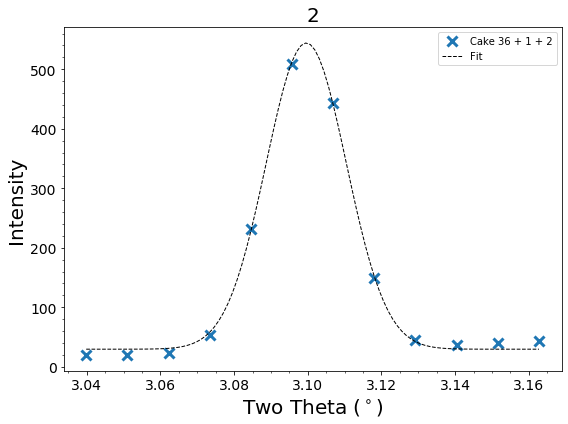

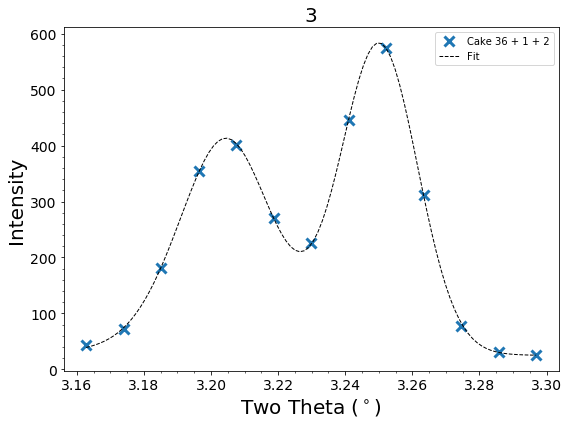

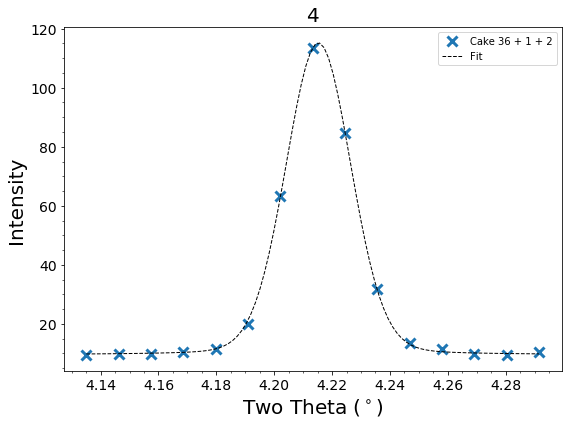

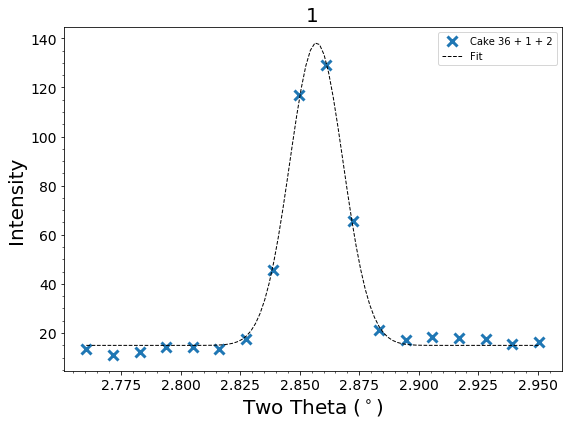

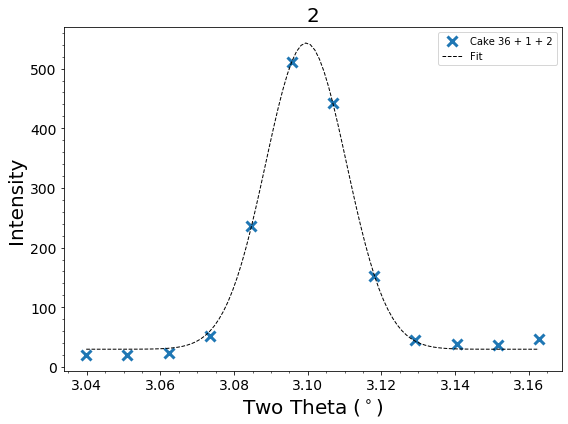

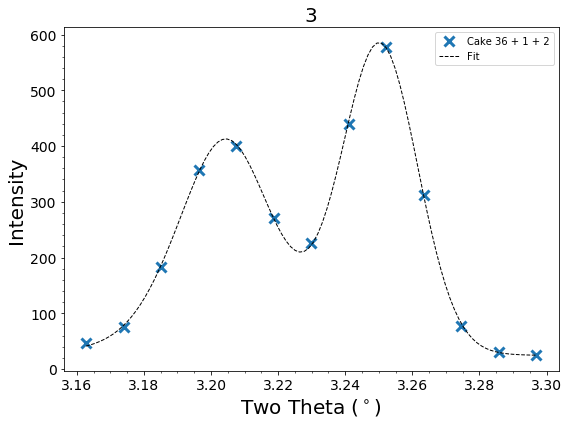

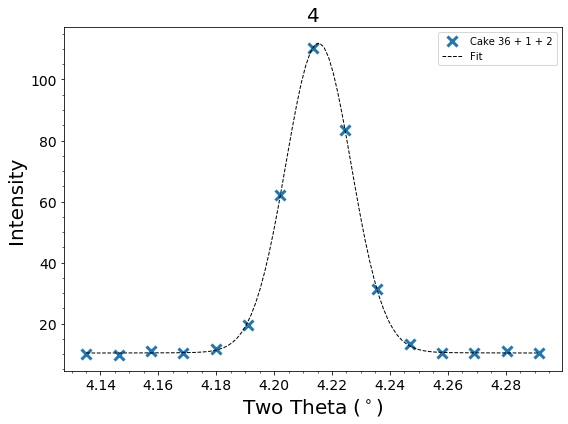

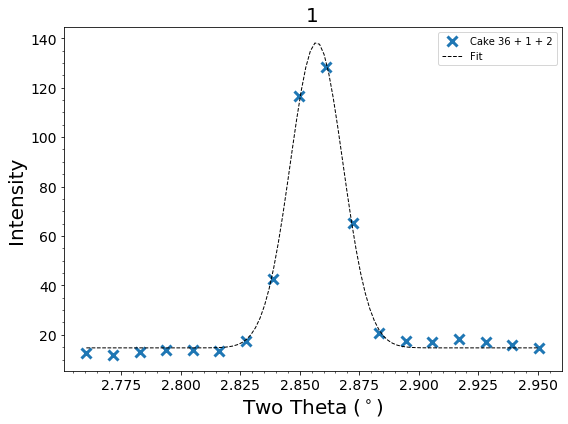

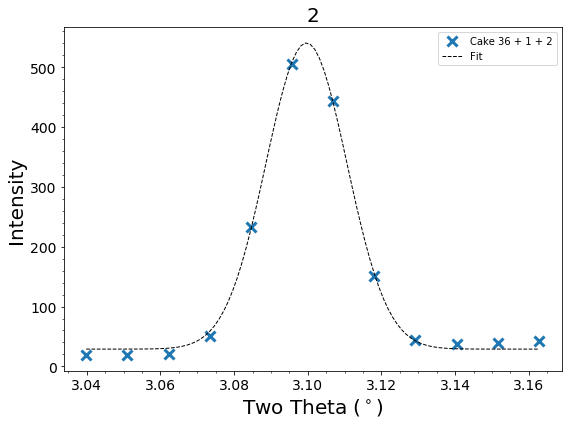

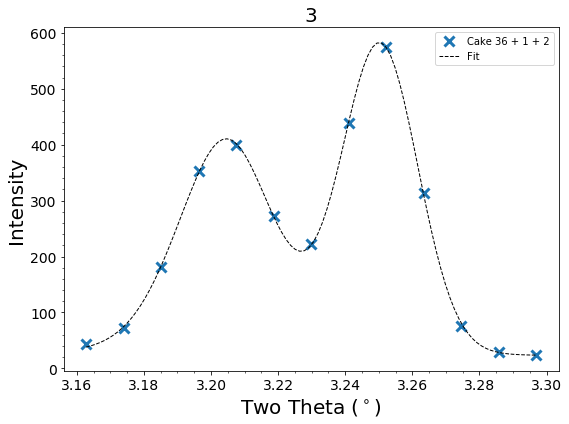

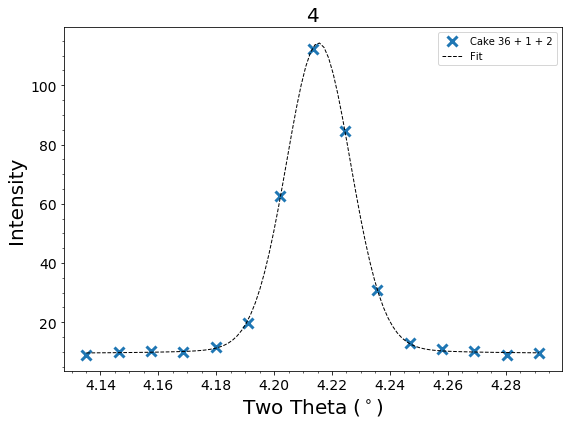

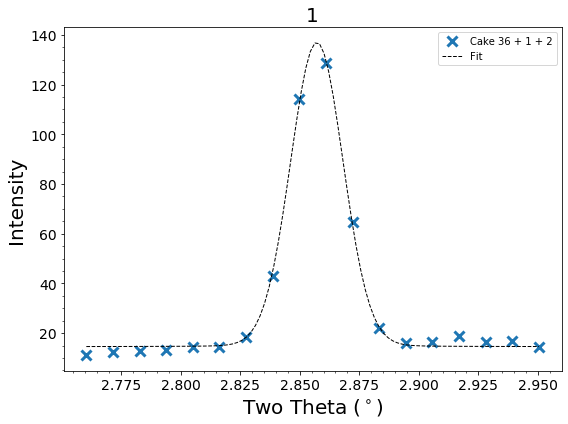

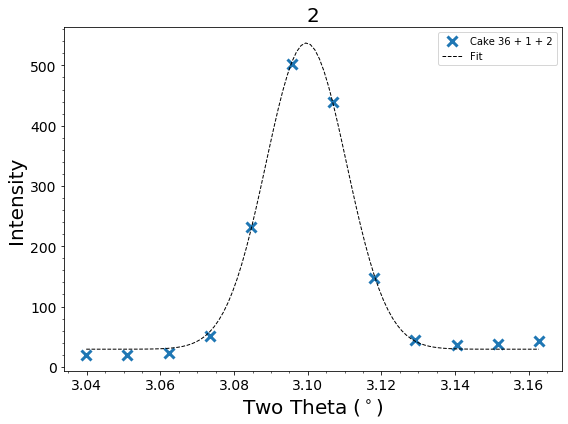

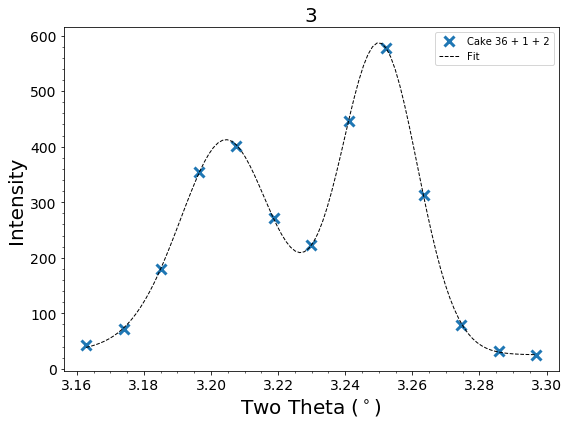

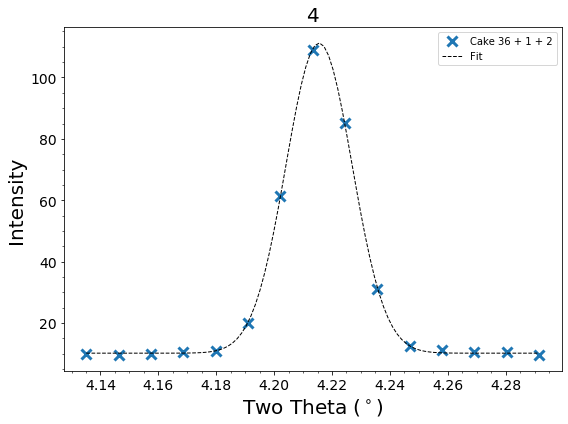

In [7]:
experiment.plot_fits()

This could potentially be a lot of plots so you can narrow down the plots you want by provinding different arguments to the plot_fits function. `num_timesteps` sets how many evenly spaced timesteps to plot (default: 5). `peak_names` is a list of one or more peak names to plot (default: all fitted peaks). `timesteps` is a list of integer values specifying which timesteps to plot, if timesteps is provided then `num_timesteps` will be ignored.

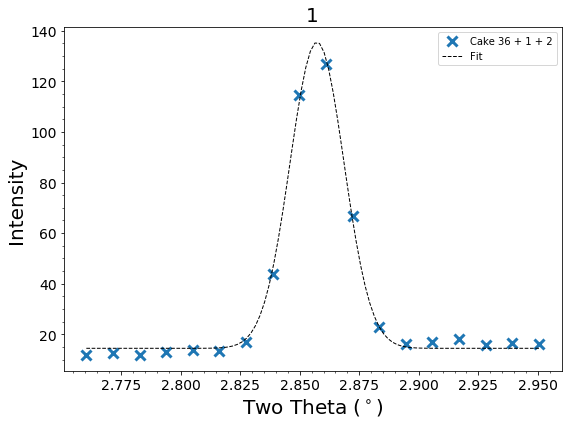

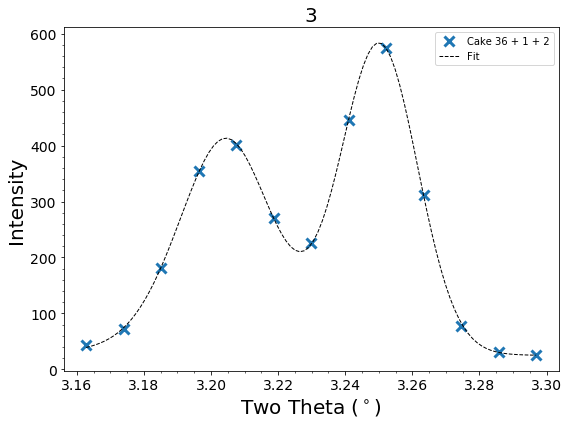

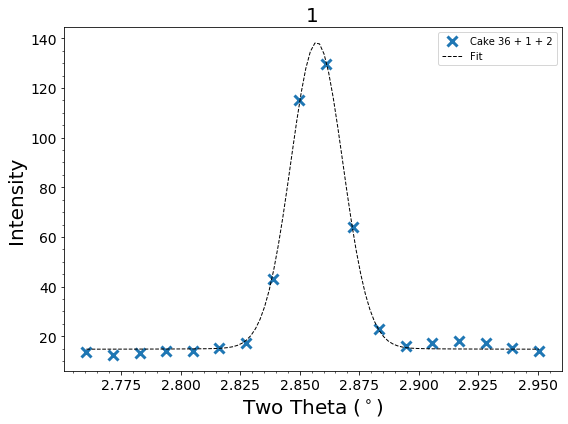

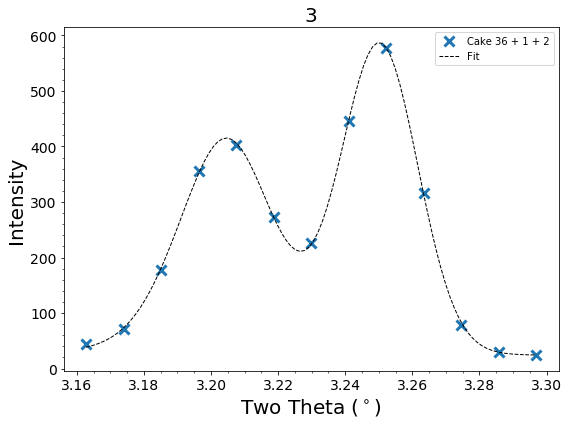

In [8]:
experiment.plot_fits(peak_names=["1", "3"], timesteps=[2, 3])

## 3.4. Fitting a subset of timesteps

Sometimes it is the case that we do not want to process all spectra in a series. Perhaps the sampling frequency is too high and we only want to fit every other spectrum or every 10th spectrum. Perhaps the interesting data is at the end so you want to skip the first 100 spectra. This can be done by  supplying an extra parameter to the `FitExperiment` object.

The *frames_to_load* parameter is a list of integer values specifying which files to load. The file stub also has to be modified here - add a python format string where the numbers need to be substituted in the file name. In this example `:05d` corresponds to a 5 digit wide integer padded with zeros. This means 1 will become 00001, 10 will become 00010 etc. For more on python sting formatting see here: https://pyformat.info/#number

The below example will be just the same as the one above except it will only load spectra 1, 3 and 4 from the example folder. Notice how the x-axis on the parameter plots scales correctly - leaving a gap at 2 seconds where there is no data.

Processing 3 diffraction patterns.



Analysis complete.


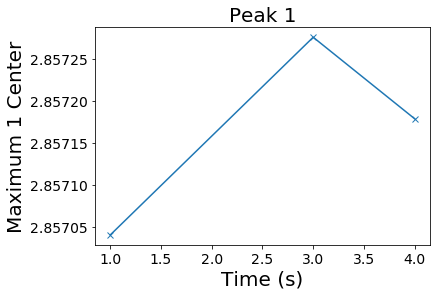

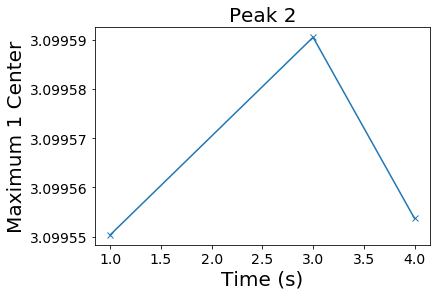

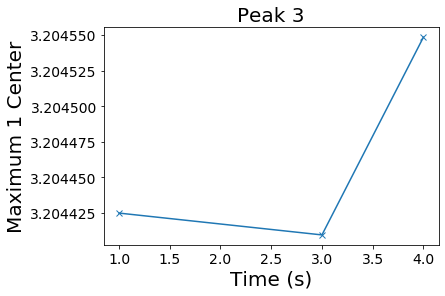

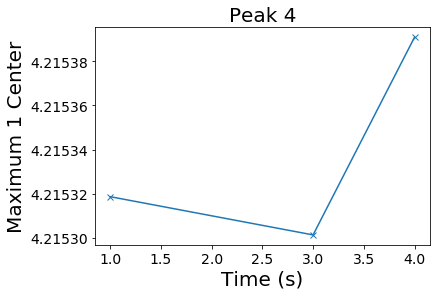

In [9]:
frames_to_load = [1, 3, 4]
file_stub = "../example_data/adc_041_7Nb_NDload_700C_15mms_{:05d}.dat"

experiment = spectrum_fitting.FittingExperiment(spectrum_time, file_stub, first_cake_angle, 
                                                cakes_to_fit, peak_params, merge_cakes, frames_to_load)

experiment.run_analysis()
for peak_name in experiment.peak_names():
    experiment.plot_fit_parameter(peak_name, "maximum_1_center", show_points=True)

To get the raw data you can use the `get_fit_parameter` method. The first column is the time while the second column is the requested parameter

In [10]:
experiment.get_fit_parameter("1", "maximum_1_center")

array([[1.        , 2.85704039],
       [3.        , 2.85727608],
       [4.        , 2.85717889]])

Once you have done an experiment it may be desirable to save the fits to be able to refer back to them later.

This can be done using the `save` method of the `FitExperiment` object.

In [11]:
experiment.save("experiment.dump")

Saving data to dump file.
Data successfully saved to dump file.


This file is a compressed binary file and so is not human readable. Note that although the file is compressed, the output may well be large - typically on the order of the size of the input data since the input data is embedded in the object.

To read in a previously saved `FitExperiment` object, use the `spectrum_fitting.load_dump` method. This returns a new `FitExperiment` with the saved fits which you can operate on just as before.

Loading data from dump file.
Data successfully loaded from dump file.


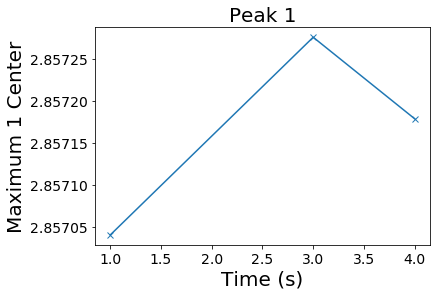

In [12]:
old_experiment = spectrum_fitting.load_dump("experiment.dump")
experiment.plot_fit_parameter("1", "maximum_1_center", show_points=True)

## 3.5. Using previous fits as a starting point for the next fit

It is possible to use the result of a fit from a previous time step as the starting condition for the next fit. You can do this by using the reuuse_fits parameter of the `run_analysis` method. 

In [13]:
experiment.run_analysis(reuse_fits=True)

Processing 3 diffraction patterns.



Analysis complete.


This may be useful if the fits change little between timesteps as in theory the previous fit should be a good starting point for the next one. If the fits are quite different between timesteps it is likely better to not reuse the fits. In this case the code will make an educated guess about the parameters instead.

We have previously found that reusing the fits can cause poor fitting performance, taking many iterations to complete each fit. The reason for this is not currently understood. Try with and without reusing fits and see which works best for your dataset.